# Машинное обучение 1, ПМИ ФКН ВШЭ

## Семинар 4

## Подготовка данных

In [1]:
%pylab inline

import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.datasets import fetch_20newsgroups

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score

import warnings
warnings.simplefilter("ignore")

Populating the interactive namespace from numpy and matplotlib


## Работа с текстовыми данными

Как правило, модели машинного обучения действуют в предположении, что матрица "объект-признак" является вещественнозначной, поэтому при работе с текстами сперва для каждого из них необходимо составить его признаковое описание. Для этого широко используются техники векторизации, tf-idf и пр. Рассмотрим их на примере датасета новостей о разных топиках.

Сперва загрузим данные:

In [2]:
data = fetch_20newsgroups(subset='all', categories=['comp.graphics', 'sci.med'])

Данные содержат тексты новостей, которые надо классифицировать на два раздела: компьютерные науки и медицинские.

In [3]:
data['target_names']

['comp.graphics', 'sci.med']

In [4]:
texts = data['data']
target = data['target']

Например:

In [5]:
texts[0]

'From: dyer@spdcc.com (Steve Dyer)\nSubject: Re: Analgesics with Diuretics\nOrganization: S.P. Dyer Computer Consulting, Cambridge MA\n\nIn article <ofk=lve00WB2AvUktO@andrew.cmu.edu> Lawrence Curcio <lc2b+@andrew.cmu.edu> writes:\n>I sometimes see OTC preparations for muscle aches/back aches that\n>combine aspirin with a diuretic.\n\nYou certainly do not see OTC preparations advertised as such.\nThe only such ridiculous concoctions are nostrums for premenstrual\nsyndrome, ostensibly to treat headache and "bloating" simultaneously.\nThey\'re worthless.\n\n>The idea seems to be to reduce\n>inflammation by getting rid of fluid. Does this actually work? \n\nThat\'s not the idea, and no, they don\'t work.\n\n-- \nSteve Dyer\ndyer@ursa-major.spdcc.com aka {ima,harvard,rayssd,linus,m2c}!spdcc!dyer\n'

In [6]:
data['target_names'][target[0]]

'sci.med'

In [7]:
texts_train, texts_test, y_train, y_test = train_test_split(
    texts, target, test_size=0.2, random_state=10
)

### Bag-of-words

Самый очевидный способ формирования признакового описания текстов — векторизация. Пусть у нас имеется коллекция текстов $D = \{d_i\}_{i=1}^l$ и словарь всех слов, встречающихся в выборке $V = \{v_j\}_{j=1}^d.$ В этом случае некоторый текст $d_i$ описывается вектором $(x_{ij})_{j=1}^d,$ где
$$x_{ij} = \sum_{v \in d_i} [v = v_j].$$

Таким образом, текст $d_i$ описывается вектором количества вхождений каждого слова из словаря в данный текст.

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(encoding='utf8')
_ = vectorizer.fit(texts_train)
len(vectorizer.vocabulary_)

29227

Результатом является разреженная матрица.

In [9]:
vectorizer.transform(texts_train[:1])

<1x29227 sparse matrix of type '<class 'numpy.int64'>'
	with 43 stored elements in Compressed Sparse Row format>

In [10]:
print(vectorizer.transform(texts_train[:1]).indices)
print(vectorizer.transform(texts_train[:1]).data)

[  451  3280  3285  4133  4134  5214  5848  7692  8797  9094  9438  9616
  9904 11526 12024 12364 13304 13697 14400 14592 14944 14950 16427 17425
 18814 19241 19490 20697 20955 20984 21019 21280 21693 21990 22035 22535
 23585 25311 26187 26499 26956 28495 28772]
[1 1 1 2 2 3 1 1 4 1 1 1 5 2 1 1 1 1 4 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 5 1 1]


Подберем оптимальные гиперпараметры по сетке и обучим модель. Учить будем логистическую регрессию, так как мы решаем задачу бинарной классификации, а для оценки качества будем использовать точность 
$$
Accuracy(\hat{y}, y) = \frac{1}{N} \sum_{i=1}^N [\hat{y_i} = y_i]
$$

In [11]:
def train_model(X_train, y_train):
    alphas = np.logspace(-1, 3, 10)
    searcher = GridSearchCV(LogisticRegression(), [{'C': alphas, 'max_iter': [500]}],
                            scoring='accuracy', cv=5, n_jobs=-1)
    searcher.fit(X_train, y_train)

    best_alpha = searcher.best_params_["C"]
    print("Best alpha = %.4f" % best_alpha)
    
    model = LogisticRegression(C=best_alpha, max_iter=500)
    model.fit(X_train, y_train)
    
    return model

In [12]:
X_train = vectorizer.transform(texts_train)
X_test = vectorizer.transform(texts_test)

In [13]:
model = train_model(X_train, y_train)

print("Train accuracy = %.4f" % accuracy_score(y_train, model.predict(X_train)))
print("Test accuracy = %.4f" % accuracy_score(y_test, model.predict(X_test)))

Best alpha = 0.7743
Train accuracy = 1.0000
Test accuracy = 0.9720


### TF-IDF

Ещё один способ работы с текстовыми данными — [TF-IDF](https://en.wikipedia.org/wiki/Tf–idf) (**T**erm **F**requency–**I**nverse **D**ocument **F**requency). Рассмотрим коллекцию текстов $D$.  Для каждого уникального слова $t$ из документа $d \in D$ вычислим следующие величины:

1. Term Frequency – количество вхождений слова в отношении к общему числу слов в тексте:
$$\text{tf}(t, d) = \frac{n_{td}}{\sum_{t \in d} n_{td}},$$
где $n_{td}$ — количество вхождений слова $t$ в текст $d$.
1. Inverse Document Frequency
$$\text{idf}(t, D) = \log \frac{\left| D \right|}{\left| \{d\in D: t \in d\} \right|},$$
где $\left| \{d\in D: t \in d\} \right|$ – количество текстов в коллекции, содержащих слово $t$.

Тогда для каждой пары (слово, текст) $(t, d)$ вычислим величину:

$$\text{tf-idf}(t,d, D) = \text{tf}(t, d)\cdot \text{idf}(t, D).$$

Отметим, что значение $\text{tf}(t, d)$ корректируется для часто встречающихся общеупотребимых слов при помощи значения $\text{idf}(t, D)$.

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(encoding='utf8')
_ = vectorizer.fit(texts_train)
len(vectorizer.vocabulary_)

29227

На выходе получаем разреженную матрицу.

In [15]:
vectorizer.transform(texts_train[:1])

<1x29227 sparse matrix of type '<class 'numpy.float64'>'
	with 43 stored elements in Compressed Sparse Row format>

In [16]:
print(vectorizer.transform(texts[:1]).indices)
print(vectorizer.transform(texts[:1]).data)

[29097 28831 28793 28751 28665 27566 26802 26499 26318 26283 26211 26209
 25758 25396 25311 25072 24692 24588 24253 23753 23743 22882 22873 22227
 22035 22002 21137 21124 19566 19553 19490 19356 19263 19241 18937 18935
 18816 18280 16947 16821 16812 16775 16445 16140 16116 14432 14253 14120
 14015 13218 13150 12376 12024 11805 11721 10241 10080  9773  9741  9712
  9632  9631  8497  7916  7743  7692  7482  7473  7316  6729  6385  6167
  5606  5186  4963  4616  4575  4555  4461  4138  4127  4097  3818  3633
  3486  3419]
[0.02847645 0.03142552 0.10526438 0.10312729 0.05644174 0.08756307
 0.07828735 0.05600843 0.02587729 0.07735152 0.05526081 0.04728733
 0.07421514 0.09664853 0.01676178 0.123904   0.25103298 0.06939308
 0.09992653 0.05728882 0.10066724 0.1015241  0.09846807 0.08101145
 0.05042139 0.08830816 0.23376552 0.12170482 0.18525966 0.12170482
 0.01735912 0.04445822 0.12170482 0.01877742 0.05769067 0.12170482
 0.03931898 0.08550803 0.06326732 0.07149103 0.08830816 0.12170482
 0.082

Подберем оптимальные гиперпараметры по сетке и обучим модель.

In [17]:
X_train = vectorizer.transform(texts_train)
X_test = vectorizer.transform(texts_test)

In [18]:
model = train_model(X_train, y_train)

print("Train accuracy = %.4f" % accuracy_score(y_train, model.predict(X_train)))
print("Test accuracy = %.4f" % accuracy_score(y_test, model.predict(X_test)))

Best alpha = 1000.0000
Train accuracy = 1.0000
Test accuracy = 0.9873


## Стемминг и лемматизация

Заметим, что одно и то же слово может встречаться в различных формах (например, "сотрудник" и "сотрудника"), но описанные выше методы интерпретируют их как различные слова, что делает признаковое описание избыточным. Устранить эту проблему можно при помощи **лемматизации** и **стемминга**.

### Стемминг

[**Stemming**](https://en.wikipedia.org/wiki/Stemming) –  это процесс нахождения основы слова. В результате применения данной процедуры однокоренные слова, как правило, преобразуются к одинаковому виду.

**Примеры стемминга:**

| Word        | Stem           |
| ----------- |:-------------:|
| вагон | вагон |
| вагона | вагон |
| вагоне | вагон |
| вагонов | вагон |
| вагоном | вагон |
| вагоны | вагон |
| важная | важн |
| важнее | важн |
| важнейшие | важн |
| важнейшими | важн |
| важничал | важнича |
| важно | важн |

[Snowball](http://snowball.tartarus.org/) – фрэймворк для написания алгоритмов стемминга. Алгоритмы стемминга отличаются для разных языков и используют знания о конкретном языке – списки окончаний для разных чистей речи, разных склонений и т.д. Пример алгоритма для русского языка – [Russian stemming](http://snowballstem.org/algorithms/russian/stemmer.html).

In [19]:
import nltk
stemmer = nltk.stem.snowball.RussianStemmer()

In [20]:
print(stemmer.stem(u'машинное'), stemmer.stem(u'обучение'))

машин обучен


Попробуем применить **стемминг** для предобработки текста перед векторизацией. Векторизовывать будем с помощью **tf-idf**, так как такой метод показал лучшее качество.

In [21]:
stemmer = nltk.stem.snowball.EnglishStemmer()

def stem_text(text, stemmer):
    tokens = text.split()
    return ' '.join(map(lambda w: stemmer.stem(w), tokens))

stemmed_texts_train = []
for t in tqdm(texts_train):
    stemmed_texts_train.append(stem_text(t, stemmer))
    
stemmed_texts_test = []
for t in tqdm(texts_test):
    stemmed_texts_test.append(stem_text(t, stemmer))

  0%|          | 0/1570 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

In [22]:
print(texts_train[1])

From: black@sybase.com (Chris Black)
Subject: cystic breast disease
Organization: Sybase, Inc.
Lines: 18

My mom has just been diagnosed with cystic breast disease -- a big
relief, as it was a lump that could have been cancer.  Her doctor says
she should go off caffeine and chocolate for 6 months, as well as
stopping the estrogen she's been taking for menopause-related reasons.
She's not thrilled with this, I think especially because she just gave
up cigarettes -- soon she won't have any pleasures left!  Now, I thought
I'd heard that cystic breasts were common and not really a health risk.
Is this accurate?  If so, why is she being told to make various
sacrifices to treat something that's not that big of a deal?

Thanks for any information.

-- Chris

-- 
black@sybase.com

Note:  My mailer tends to garble subject lines.  



In [23]:
print(stemmed_texts_train[1])

from: black@sybase.com (chris black) subject: cystic breast diseas organization: sybase, inc. lines: 18 my mom has just been diagnos with cystic breast diseas -- a big relief, as it was a lump that could have been cancer. her doctor say she should go off caffein and chocol for 6 months, as well as stop the estrogen she been take for menopause-rel reasons. she not thrill with this, i think especi becaus she just gave up cigarett -- soon she won't have ani pleasur left! now, i thought i'd heard that cystic breast were common and not realli a health risk. is this accurate? if so, whi is she be told to make various sacrific to treat someth that not that big of a deal? thank for ani information. -- chris -- black@sybase.com note: my mailer tend to garbl subject lines.


In [24]:
vectorizer = TfidfVectorizer(encoding='utf8')
_ = vectorizer.fit(stemmed_texts_train)
len(vectorizer.vocabulary_)

27715

In [25]:
X_train = vectorizer.transform(stemmed_texts_train)
X_test = vectorizer.transform(stemmed_texts_test)

In [26]:
model = train_model(X_train, y_train)

print("Train accuracy = %.4f" % accuracy_score(y_train, model.predict(X_train)))
print("Test accuracy = %.4f" % accuracy_score(y_test, model.predict(X_test)))

Best alpha = 129.1550
Train accuracy = 1.0000
Test accuracy = 0.9924


### Лемматизация

[Лемматизация](https://en.wikipedia.org/wiki/Lemmatisation) — процесс приведения слова к его нормальной форме (**лемме**):
- для существительных — именительный падеж, единственное число;
- для прилагательных — именительный падеж, единственное число, мужской род;
- для глаголов, причастий, деепричастий — глагол в инфинитиве.

Например, для русского языка есть библиотека pymorphy2.

In [27]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [28]:
morph.parse('играющих')[0]

Parse(word='играющих', tag=OpencorporaTag('PRTF,Subx,impf,tran,pres,actv plur,gent'), normal_form='играть', score=0.6, methods_stack=((DictionaryAnalyzer(), 'играющих', 1694, 34),))

Сравним работу стеммера и лемматизатора на примере:

In [29]:
stemmer = nltk.stem.snowball.RussianStemmer()
print(stemmer.stem('играющих'))

игра


In [30]:
print(morph.parse('играющих')[0].normal_form)

играть


Для английского языка будем пользоваться лемматизатором из библиотеки **nltk**.

In [31]:
from nltk.stem import WordNetLemmatizer
  
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text, stemmer):
    tokens = text.split()
    return ' '.join(map(lambda w: lemmatizer.lemmatize(w), tokens))

lemmatized_texts_train = []
for t in tqdm(texts_train):
    lemmatized_texts_train.append(lemmatize_text(t, stemmer))
    
lemmatized_texts_test = []
for t in tqdm(texts_test):
    lemmatized_texts_test.append(lemmatize_text(t, stemmer))

  0%|          | 0/1570 [00:00<?, ?it/s]

  0%|          | 0/393 [00:00<?, ?it/s]

In [32]:
print(lemmatized_texts_train[1])

From: black@sybase.com (Chris Black) Subject: cystic breast disease Organization: Sybase, Inc. Lines: 18 My mom ha just been diagnosed with cystic breast disease -- a big relief, a it wa a lump that could have been cancer. Her doctor say she should go off caffeine and chocolate for 6 months, a well a stopping the estrogen she's been taking for menopause-related reasons. She's not thrilled with this, I think especially because she just gave up cigarette -- soon she won't have any pleasure left! Now, I thought I'd heard that cystic breast were common and not really a health risk. Is this accurate? If so, why is she being told to make various sacrifice to treat something that's not that big of a deal? Thanks for any information. -- Chris -- black@sybase.com Note: My mailer tends to garble subject lines.


In [33]:
print(stemmed_texts_train[1])

from: black@sybase.com (chris black) subject: cystic breast diseas organization: sybase, inc. lines: 18 my mom has just been diagnos with cystic breast diseas -- a big relief, as it was a lump that could have been cancer. her doctor say she should go off caffein and chocol for 6 months, as well as stop the estrogen she been take for menopause-rel reasons. she not thrill with this, i think especi becaus she just gave up cigarett -- soon she won't have ani pleasur left! now, i thought i'd heard that cystic breast were common and not realli a health risk. is this accurate? if so, whi is she be told to make various sacrific to treat someth that not that big of a deal? thank for ani information. -- chris -- black@sybase.com note: my mailer tend to garbl subject lines.


In [34]:
vectorizer = TfidfVectorizer(encoding='utf8')
_ = vectorizer.fit(lemmatized_texts_train)
len(vectorizer.vocabulary_)

28717

In [35]:
X_train = vectorizer.transform(lemmatized_texts_train)
X_test = vectorizer.transform(lemmatized_texts_test)

In [36]:
model = train_model(X_train, y_train)

print("Train accuracy = %.4f" % accuracy_score(y_train, model.predict(X_train)))
print("Test accuracy = %.4f" % accuracy_score(y_test, model.predict(X_test)))

Best alpha = 359.3814
Train accuracy = 1.0000
Test accuracy = 0.9873


## Трансформация признаков и целевой переменной

Разберёмся, как может влиять трансформация признаков или целевой переменной на качество модели. 

### Логарифмирование 

Воспользуется датасетом с ценами на дома, с которым мы уже сталкивались ранее ([House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview)).

In [37]:
!wget  -O 'train_sem4.csv' -q 'https://www.dropbox.com/s/syfy4lb6xb7wdlx/_train_sem4.csv?dl=0'

In [38]:
data = pd.read_csv('train_sem4.csv')

data = data.drop(columns=["Id"])
y = data["SalePrice"]
X = data.drop(columns=["SalePrice"])

Оставим только числовые признаки, пропуски заменим средним значением.

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=100)

numeric_data = X_train.select_dtypes([np.number])
numeric_data_mean = numeric_data.mean()
numeric_features = numeric_data.columns

X_train = X_train.fillna(numeric_data_mean)[numeric_features]
X_test = X_test.fillna(numeric_data_mean)[numeric_features]

Посмотрим на распределение целевой переменной 

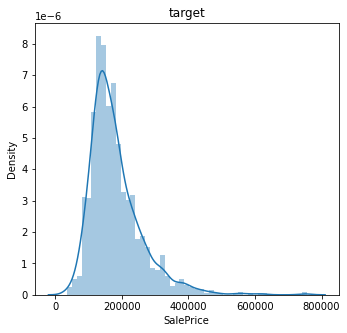

In [40]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.distplot(y, label='target')
plt.title('target')

plt.show()

Видим, что распределения несимметричные с тяжёлыми правыми хвостами.

Если разбирать линейную регрессию c MSE ошибкой с [вероятностной](https://github.com/esokolov/ml-course-hse/blob/master/2018-fall/seminars/sem04-linregr.pdf) точки зрения, то можно получить, что шум должен быть распределён нормально. Поэтому лучше, когда целевая переменная распределена также нормально.

Если прологарифмировать целевую переменную, то её распределение станет больше похоже на нормальное:

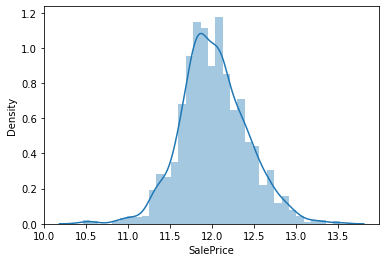

In [41]:
sns.distplot(np.log(y+1), label='target')
plt.show()

Сравним качество линейной регрессии в двух случаях:
1. Целевая переменная без изменений.
2. Целевая переменная прологарифмирована.

Не забудем вернуть во втором случае взять экспоненту от предсказаний!

In [42]:
def train_model(X_train, y_train):
    alphas = np.logspace(-2, 3, 10)
    searcher = GridSearchCV(Ridge(), [{'alpha': alphas}],
                            scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1)
    searcher.fit(X_train, np.log(y_train+1))

    best_alpha = searcher.best_params_["alpha"]
    print("Best alpha = %.4f" % best_alpha)

    return searcher.best_estimator_.fit(X_train, y_train)

In [43]:
model = train_model(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print("Train RMSE = %.4f" % mean_squared_error(y_train, y_pred_train) ** 0.5)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred_test) ** 0.5)

Best alpha = 21.5443
Train RMSE = 34823.9864
Test RMSE = 34068.8463


In [44]:
model = train_model(X_train, np.log(y_train+1))

y_pred_train = np.exp(model.predict(X_train)) - 1
y_pred_test = np.exp(model.predict(X_test)) - 1

print("Train RMSE = %.4f" % mean_squared_error(y_train, y_pred_train) ** 0.5)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred_test) ** 0.5)

Best alpha = 21.5443
Train RMSE = 38147.4237
Test RMSE = 29230.4326


Попробуем аналогично логарифмировать один из признаков, имеющих также смещённое распределение (этот признак был вторым по важности!)

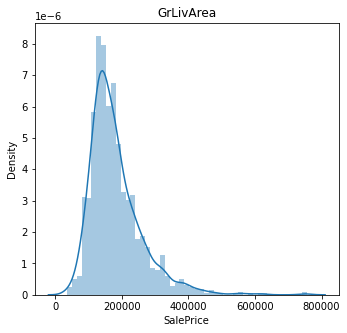

In [45]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.distplot(y, label='GrLivArea')
plt.title('GrLivArea')

plt.show()

In [46]:
X_train.GrLivArea = np.log(X_train.GrLivArea + 1)
X_test.GrLivArea = np.log(X_test.GrLivArea + 1)

In [47]:
model = train_model(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print("Train RMSE = %.4f" % mean_squared_error(y_train, y_pred_train) ** 0.5)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred_test) ** 0.5)

Best alpha = 0.0100
Train RMSE = 34781.6496
Test RMSE = 33967.9876


In [48]:
model = train_model(X_train, np.log(y_train+1))

y_pred_train = np.exp(model.predict(X_train[numeric_features])) - 1
y_pred_test = np.exp(model.predict(X_test[numeric_features])) - 1

print("Train RMSE = %.4f" % mean_squared_error(y_train, y_pred_train) ** 0.5)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred_test) ** 0.5)

Best alpha = 0.0100
Train RMSE = 33553.2647
Test RMSE = 31070.1888


Как видим, преобразование признаков влияет совсем не так.

## Категориальные признаки

In [74]:
# ! pip install category_encoders

In [50]:
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [51]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=100)

In [52]:
numeric = list(X_train.select_dtypes(include=np.number).columns)
categorical = list(X_train.dtypes[X_train.dtypes == "object"].index)

In [53]:
X_train[categorical] = X_train[categorical].fillna("NotGiven")
X_test[categorical] = X_test[categorical].fillna("NotGiven")

numeric_data_mean = X_train[numeric_features].mean()
X_train[numeric] = X_train[numeric].fillna(numeric_data_mean)
X_test[numeric] = X_test[numeric].fillna(numeric_data_mean)

### One Hot Encoder

In [54]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical)
])

pipeline = Pipeline(steps=[
    ('ohe', column_transformer),
    ('regression', Ridge())
])

In [55]:
alphas = np.logspace(-2, 3, 10)
searcher = GridSearchCV(pipeline, [{'regression__alpha': alphas}],
                        scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1)
searcher.fit(X_train, np.log(y_train+1))

best_alpha = searcher.best_params_["regression__alpha"]
print("Best alpha = %.4f" % best_alpha)

Best alpha = 5.9948


In [56]:
model = searcher.best_estimator_

y_pred_train = np.exp(model.predict(X_train)) - 1
y_pred_test = np.exp(model.predict(X_test)) - 1

print("Train RMSE = %.4f" % mean_squared_error(y_train, y_pred_train) ** 0.5)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred_test) ** 0.5)

Train RMSE = 31298.1531
Test RMSE = 35505.9123


### Счетчики (mean target encoding)

При кодировании категориального признака каждое его значение будем заменять на среднее значение целевой переменной для всех объектов с такой категорией.

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell}\left[f_j(x)=f_j\left(x_i\right)\right] y_i}{\sum_{i=1}^{\ell}\left[f_j(x)=f_j\left(x_i\right)\right]}
$$

In [57]:
column_transformer = ColumnTransformer([
    ('te', TargetEncoder(smoothing=1.0), categorical)
], remainder='passthrough')

pipeline = Pipeline(steps=[
    ('scale', column_transformer),
    ('regression', Ridge())
])

In [58]:
alphas = np.logspace(-2, 3, 10)
searcher = GridSearchCV(pipeline, [{'regression__alpha': alphas}],
                        scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1)
searcher.fit(X_train, np.log(y_train+1))

best_alpha = searcher.best_params_["regression__alpha"]
print("Best alpha = %.4f" % best_alpha)

Best alpha = 5.9948


In [59]:
model = searcher.best_estimator_

y_pred_train = np.exp(model.predict(X_train)) - 1
y_pred_test = np.exp(model.predict(X_test)) - 1

print("Train RMSE = %.4f" % mean_squared_error(y_train, y_pred_train) ** 0.5)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred_test) ** 0.5)

Train RMSE = 29544.4295
Test RMSE = 26965.3038


## Транзакционные данные

Напоследок посмотрим, как можно извлекать признаки из транзакционных данных. 

Транзакционные данные характеризуются тем, что есть много строк, характеризующихся моментов времени и некоторым числом (суммой денег, например). При этом если это банк, то каждому человеку принадлежит не одна транзакция, а чаще всего надо предсказывать некоторые сущности для клиентов. Таким образом, надо получить признаки для пользователей из множества их транзакций. Этим мы и займёмся.

Для примера возьмём данные [отсюда](https://www.kaggle.com/regivm/retailtransactiondata/). Задача детектирования фродовых клиентов.

In [60]:
!wget  -O 'Retail_Data_Response.csv' -q 'https://www.dropbox.com/s/le9icl9syo22thh/Retail_Data_Response.csv?dl=0'
!wget  -O 'Retail_Data_Transactions.csv' -q 'https://www.dropbox.com/s/obsxryxpfsdz3ut/Retail_Data_Transactions.csv?dl=0'

In [61]:
customers = pd.read_csv('Retail_Data_Response.csv')
transactions = pd.read_csv('Retail_Data_Transactions.csv')

In [62]:
customers.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [63]:
transactions.head()

,customer_id,trans_date,tran_amount
0,CS5295,11-Feb-13,35
1,CS4768,15-Mar-15,39
2,CS2122,26-Feb-13,52
3,CS1217,16-Nov-11,99
4,CS1850,20-Nov-13,78


In [64]:
transactions.trans_date = transactions.trans_date.apply(
    lambda x: datetime.datetime.strptime(x, '%d-%b-%y'))

Посмотрим на распределение целевой переменной:

In [65]:
customers.response.mean()

0.09398605461940732

Получаем примерно 1 к 9 положительных примеров. Если такие данные разбивать на части для кросс валидации, то может получиться так, что в одну из частей попадёт слишком мало положительных примеров, а в другую — наоборот. На случай такого неравномерного баланса классов есть StratifiedKFold, который бьёт данные так, чтобы баланс классов во всех частях был одинаковым.

In [66]:
from sklearn.model_selection import StratifiedKFold

Когда строк на каждый объект много, можно считать различные статистики. Например, средние, минимальные и максимальные суммы, потраченные клиентом, количество транзакий, ...

In [67]:
agg_transactions = transactions.groupby('customer_id').tran_amount.agg(
    ['mean', 'std', 'count', 'min', 'max']).reset_index()

data = pd.merge(customers, agg_transactions, how='left', on='customer_id')

data.head()

,customer_id,response,mean,std,count,min,max
0,CS1112,0,67.466667,19.766012,15,36,105
1,CS1113,0,74.500000,21.254102,20,36,98
2,CS1114,1,75.368421,21.341692,19,37,105
3,CS1115,1,75.409091,18.151896,22,41,104
4,CS1116,1,65.923077,22.940000,13,40,105


In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

np.mean(cross_val_score(
    LogisticRegression(solver='newton-cg'),
    X=data.drop(['customer_id', 'response'], axis=1),
    y=data.response,
    cv=StratifiedKFold(n_splits=3),
    scoring='roc_auc'))

0.7138460124535347

Но каждая транзакция снабжена датой! Можно посчитать статистики только по свежим транзакциям. Добавим их.

In [70]:
transactions.trans_date.min(), transactions.trans_date.max()

(Timestamp('2011-05-16 00:00:00'), Timestamp('2015-03-16 00:00:00'))

In [71]:
agg_transactions = transactions.loc[transactions.trans_date.apply(
    lambda x: x.year == 2014)].groupby('customer_id').tran_amount.agg(
    ['mean', 'std', 'count', 'min', 'max']).reset_index()

In [72]:
data = pd.merge(data, agg_transactions, how='left', on='customer_id', suffixes=('', '_2014'))
data = data.fillna(0)

In [73]:
np.mean(cross_val_score(
    LogisticRegression(solver='newton-cg'),
    X=data.drop(['customer_id', 'response'], axis=1),
    y=data.response,
    cv=StratifiedKFold(n_splits=3),
    scoring='roc_auc'))

0.7492944117908228

Можно также считать дату первой и последней транзакциями пользователей, среднее время между транзакциями и прочее.